In [24]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime as dt
import seaborn as sns


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# import data

# bike rentals (https://data.london.gov.uk/dataset/number-bicycle-hires)
# metadata = pd.read_excel(Path.cwd().parent/"files"/"tfl-daily-cycle-hires.xlsx")
bike_rentals = pd.read_excel(Path.cwd().parent/"files"/"Assignment3"/"bike_rentals_london.xlsx", sheet_name = 'Data')

# covid (https://data.london.gov.uk/dataset/coronavirus--covid-19--cases)
covid = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/"corona_london.csv")

# weather (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1)
# metadata od the weather data (https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WH_Table.html)
li = []

for i in range(2010,2020,1):

    dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)
    li.append(dummy)

weather = pd.concat(li, axis=0, ignore_index=True)

del li, dummy, i



C:\Users\phili\AppData\Local\Temp\ipykernel_10688\1484035747.py:16: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)


In [3]:
# Preprocessing bike rental data

bike_rentals_month = bike_rentals[['Month', 'Number of Bicycle Hires.1', 'Average Hire Time (mins)']]
# drop NaN rows
bike_rentals_month = bike_rentals_month[bike_rentals_month['Number of Bicycle Hires.1'].notna()]

bike_rentals_year = bike_rentals[['Year', 'Number of Bicycle Hires.2']]
bike_rentals_year = bike_rentals_year.iloc[:bike_rentals_year.Year.isnull().values.argmax()]

bike_rentals = bike_rentals.drop(columns = ['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8', 'Month.1', 'Month', 'Number of Bicycle Hires.1', \
    'Average Hire Time (mins)', 'Year', 'Number of Bicycle Hires.2'])

bike_rentals.head()

,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [4]:
# Preprocessing weather data

# drop columns with only NaNs
weather = weather.dropna(axis=1, how='all')
# drop rows with only NaNs
weather = weather.dropna(axis=0, how='all')
# drop columns version_num as all values = 1.0, id as all values = 3772, met_domain_name as all values = SYNOP,
# id_type = WMO , 'src_id' = 708
weather = weather.drop(columns = ['version_num', 'id', 'met_domain_name', 'id_type', 'src_id'])
# drop rows where ob_time == 'end data' as all other rows are NaN
weather = weather.drop(weather[weather.ob_time == 'end data'].index)
# drop column wind_speed_unit_id as all values = 4
weather = weather.drop(columns = ['wind_speed_unit_id'])
# drop columns as the method and manner of measurement are not relevant for this analysis
weather = weather.drop(columns = ['rec_st_ind', 'src_opr_type', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'dewpoint_j', \
    'wetb_temp_j', 'rltv_hum_j', 'midas_stmp_etime', 'meto_stmp_time', 'prst_wx_id'])
# quality control out of the scope of the project -> drop all columns
weather = weather.drop(columns = ['wind_direction_q', 'wind_speed_q', 'prst_wx_id_q', 'cld_ttl_amt_id_q', 'cld_base_ht_q',\
    'visibility_q', 'msl_pressure_q', 'cld_amt_id_1_q', 'cld_base_ht_id_1_q', 'cld_amt_id_2_q', 'cld_base_ht_id_2_q', 'cld_amt_id_3_q',\
    'cld_base_ht_id_3_q', 'stn_pres_q', 'alt_pres_q', 'q10mnt_mxgst_spd_q', 'wmo_hr_sun_dur_q', 'snow_depth_q', 'drv_hr_sun_dur',\
    'drv_hr_sun_dur_q'])
# drop columns not necessary for analysis
weather = weather.drop(columns = ['alt_pres', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3',\
    'cld_base_ht_id_3', 'q10mnt_mxgst_spd', 'snow_depth', 'cavok_flag'])

# drop rows where air_temperature or wind_speed = NaN
weather = weather[weather['air_temperature'].notna()]
weather = weather[weather['wind_speed'].notna()]
# converting date to datetime
weather['ob_time'] = pd.to_datetime(weather['ob_time'])
# group by day to be able to merge it with the bike rental data
weather = weather.groupby(weather['ob_time'].dt.date).mean().reset_index()
weather['ob_time'] = pd.to_datetime(weather['ob_time'])

## optional
# drop rows where cld_ttl_amt_id, cld_base_ht, visibility, wmo_hr_sun_dur depending on analysis
# weather = weather[weather['cld_ttl_amt_id'].notna()]
# weather = weather[weather['cld_base_ht'].notna()]
# weather = weather[weather['visibility'].notna()]
# weather = weather[weather['wmo_hr_sun_dur'].notna()]


## checks
# NaN check 
weather.isna().sum()

ob_time             0
wind_direction      0
wind_speed          0
cld_ttl_amt_id     43
cld_base_ht        43
visibility          2
msl_pressure        0
air_temperature     0
dewpoint            0
wetb_temp           0
rltv_hum            0
stn_pres            0
wmo_hr_sun_dur     10
dtype: int64

In [5]:
# Preprocessing covid data

# drop all dates without age information
covid = covid[covid.age_band != 'unassigned']
# drop columns area_name, area_code
covid = covid.drop(columns = ['area_name', 'area_code'])
# converting date to datetime
covid['date'] = pd.to_datetime(covid['date'])

In [6]:
# Preprocessing combing bike rentals and weather data by joining on the datetime

bike_rentals_weather = pd.merge(bike_rentals, weather, left_on='Day', right_on='ob_time')


In [7]:
# Preprocessing combing bike rentals and covid data by joining on the datetime

bike_rentals_covid = pd.merge(bike_rentals, covid, left_on='Day', right_on='date')

In [8]:
bike_rentals_weather

,Day,Number of Bicycle Hires,ob_time,wind_direction,wind_speed,cld_ttl_amt_id,cld_base_ht,visibility,msl_pressure,air_temperature,dewpoint,wetb_temp,rltv_hum,stn_pres,wmo_hr_sun_dur
0,2010-07-30,6897,2010-07-30,267.500000,6.791667,5.500000,123.750000,1883.333333,1014.687500,17.558333,10.479167,13.741667,64.450000,1011.712500,0.130435
1,2010-07-31,5564,2010-07-31,240.000000,9.333333,5.291667,102.083333,2919.583333,1011.554167,19.858333,13.708333,16.358333,69.808333,1008.612500,0.204348
2,2010-08-01,4303,2010-08-01,261.250000,5.916667,7.208333,156.666667,2879.166667,1013.225000,18.795833,11.125000,14.591667,62.675000,1010.266667,0.017391
3,2010-08-02,6642,2010-08-02,247.083333,4.708333,6.500000,173.333333,2470.833333,1016.791667,18.837500,10.483333,14.304167,59.066667,1013.833333,0.091304
4,2010-08-03,7966,2010-08-03,256.666667,6.750000,4.666667,177.083333,1908.333333,1015.687500,17.870833,11.225000,14.225000,66.145833,1012.729167,0.169565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,2019-12-27,11718,2019-12-27,197.500000,4.208333,7.541667,27.083333,1799.583333,1028.804167,7.291667,5.516667,6.500000,88.387500,1025.695833,0.000000
3426,2019-12-28,11414,2019-12-28,167.916667,5.666667,7.958333,25.416667,1532.083333,1036.316667,8.208333,6.550000,7.437500,89.241667,1033.162500,0.000000
3427,2019-12-29,12256,2019-12-29,193.750000,7.125000,6.166667,72.291667,1651.666667,1033.554167,7.404167,5.158333,6.404167,85.612500,1030.408333,0.091304
3428,2019-12-30,16166,2019-12-30,229.166667,5.583333,4.250000,118.181818,781.666667,1029.683333,6.808333,5.695833,6.295833,93.158333,1026.550000,0.152174


In [9]:
bins= [0.0,15.0,30.0,60.0,91.0]
labels = ['Child','Young Adult','Middle-Age Adult','Senior-Citizen']
bike_rentals_covid['AgeGroup'] = pd.cut(bike_rentals_covid['age_lower'], bins=bins, labels=labels, right=False)

In [10]:
bike_rentals_covid = bike_rentals_covid.drop(["age_band"], axis=1)

In [11]:
bike_rentals_covid

,Day,Number of Bicycle Hires,date,cases,rolling_sum,rolling_rate,age_lower,age_higher,population,AgeGroup
0,2020-02-03,28267,2020-02-03,0,0,0.0,0.0,4.0,595799.0,Child
1,2020-02-03,28267,2020-02-03,0,0,0.0,5.0,9.0,606333.0,Child
2,2020-02-03,28267,2020-02-03,0,0,0.0,10.0,14.0,550753.0,Child
3,2020-02-03,28267,2020-02-03,0,0,0.0,15.0,19.0,474456.0,Young Adult
4,2020-02-03,28267,2020-02-03,1,0,0.0,20.0,24.0,556594.0,Young Adult
...,...,...,...,...,...,...,...,...,...,...
13846,2022-01-31,26806,2022-01-31,174,1057,376.9,70.0,74.0,280432.0,Senior-Citizen
13847,2022-01-31,26806,2022-01-31,118,695,353.8,75.0,79.0,196419.0,Senior-Citizen
13848,2022-01-31,26806,2022-01-31,79,447,296.1,80.0,84.0,150980.0,Senior-Citizen
13849,2022-01-31,26806,2022-01-31,43,255,271.8,85.0,89.0,93808.0,Senior-Citizen


<AxesSubplot:title={'center':'cases'}, xlabel='AgeGroup'>

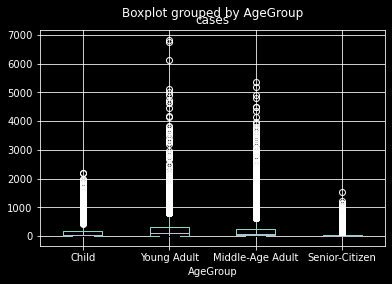

In [12]:
bike_rentals_covid.boxplot('cases','AgeGroup')

In [13]:
bike_rentals_covid['year']=bike_rentals_covid.Day.dt.year
bike_rentals_covid['pickup_date']=bike_rentals_covid.Day.dt.date
bike_rentals_covid['pickup_day']=bike_rentals_covid.Day.dt.day
bike_rentals_covid['pickup_month']=bike_rentals_covid.Day.dt.month

# Extracting the day of the week (dow)
bike_rentals_covid['pickup_dow'] = pd.to_datetime(bike_rentals_covid['Day']).dt.dayofweek

# Type of day column

bike_rentals_covid['pickup_weekend'] = bike_rentals_covid.Day.dt.dayofweek.apply(lambda x: '0' if x <5 else '1')

In [14]:
# Adding the season
bike_rentals_covid['season']=bike_rentals_covid.Day.dt.month.apply(lambda x: 'Winter' if x <=2 else 'Spring' if x<=5 else 'Summer' 
                                             if x<=8 else 'Autumn' if x<=11 else 'Winter')

In [15]:
bike_rentals_covid = bike_rentals_covid.drop(["Day","date"], axis=1)

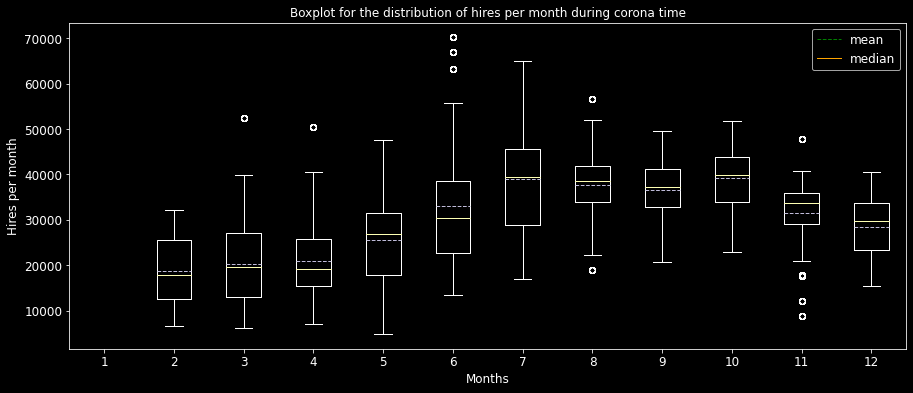

In [16]:
figure = plt.figure(figsize =(15, 6))
bikes_month=[]
for i in range(0,12):
    bikes_month.append(bike_rentals_covid[bike_rentals_covid['pickup_month']==i]['Number of Bicycle Hires'])
    #print(len(bikes[bikes['starttime_hour']==i]['pickups/hr'])) #363-365 because we remove >80 
    # Creating plot
plt.boxplot(bikes_month, showmeans=True, meanline= True)
plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='orange', label='median')
plt.xlabel("Months", fontsize=12)
plt.ylabel("Hires per month", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title("Boxplot for the distribution of hires per month during corona time")
plt.show()

In [17]:
covid_hires_per_season=bike_rentals_covid.groupby(['pickup_dow','season']).mean()['Number of Bicycle Hires'].reset_index()

In [18]:
covid_hires_per_season

,pickup_dow,season,Number of Bicycle Hires
0,0,Autumn,30097.538462
1,0,Spring,24130.703704
2,0,Summer,33763.518519
3,0,Winter,17984.000000
4,1,Autumn,33323.846154
5,1,Spring,24139.384615
6,1,Summer,37872.703704
7,1,Winter,19339.920000
8,2,Autumn,34065.576923
9,2,Spring,23301.500000


In [19]:
covid_hires_per_dow=bike_rentals_covid.groupby(['pickup_dow','pickup_weekend']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_dow

,pickup_dow,pickup_weekend,Number of Bicycle Hires
0,0,0,26621.714286
1,1,0,28847.163462
2,2,0,28816.971154
3,3,0,28499.365385
4,4,0,29066.423077
5,5,1,33551.682692
6,6,1,29895.961538


Text(0.5, 1.0, 'Hires per season')

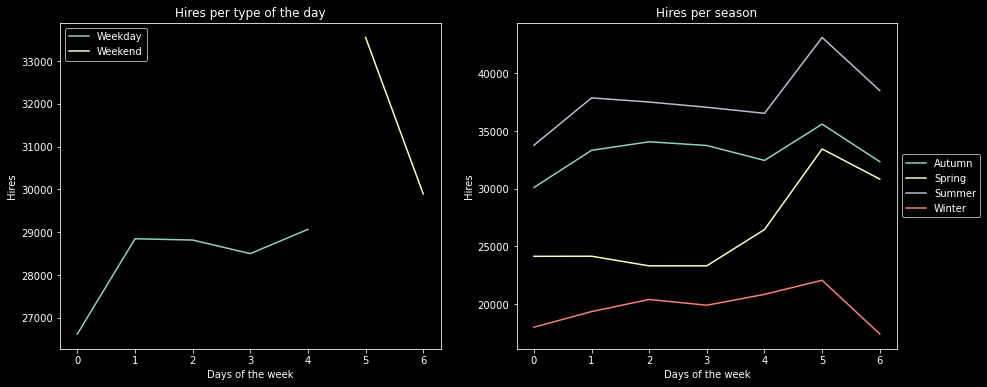

In [20]:
#Plotting pickups based on the type of the day and the season
 
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
#ax = plt.gca()
for weekday in covid_hires_per_dow['pickup_weekend'].unique():
    covid_hires_per_dow[covid_hires_per_dow.pickup_weekend==weekday].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[0],xlabel='Days of the week',ylabel='Hires')
axes[0].legend(['Weekday','Weekend'])
axes[0].set_title('Hires per type of the day')



for season in covid_hires_per_season['season'].unique():
    covid_hires_per_season[covid_hires_per_season.season==season].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[1],xlabel='Days of the week',ylabel='Hires')
axes[1].legend(covid_hires_per_season['season'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Hires per season')

In [21]:
covid_cases_per_agegroup=bike_rentals_covid.groupby(['pickup_dow','AgeGroup']).mean()['cases'].reset_index()
covid_cases_per_agegroup

,pickup_dow,AgeGroup,cases
0,0,Child,195.355556
1,0,Young Adult,348.917460
2,0,Middle-Age Adult,300.622222
3,0,Senior-Citizen,51.619048
4,1,Child,177.163462
5,1,Young Adult,363.884615
6,1,Middle-Age Adult,299.600962
7,1,Senior-Citizen,50.391484
8,2,Child,168.230769
9,2,Young Adult,366.371795


Text(0.5, 1.0, 'Covid-19 cases per day of the week per age group')

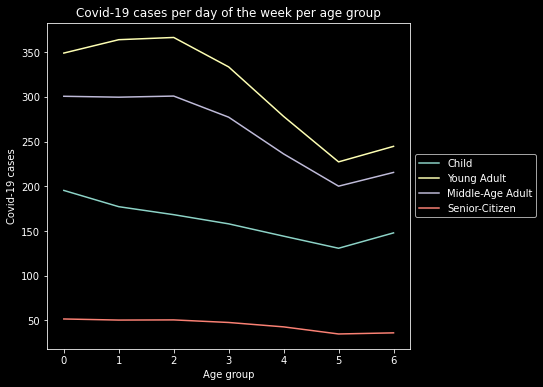

In [22]:
ax = plt.gca()
for agegroup in covid_cases_per_agegroup['AgeGroup'].unique():
    covid_cases_per_agegroup[covid_cases_per_agegroup.AgeGroup==agegroup].plot(kind='line',x='pickup_dow',y='cases',ax=ax,xlabel='Age group',ylabel='Covid-19 cases',figsize=(6.5,6))
plt.legend(covid_cases_per_agegroup['AgeGroup'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covid-19 cases per day of the week per age group')

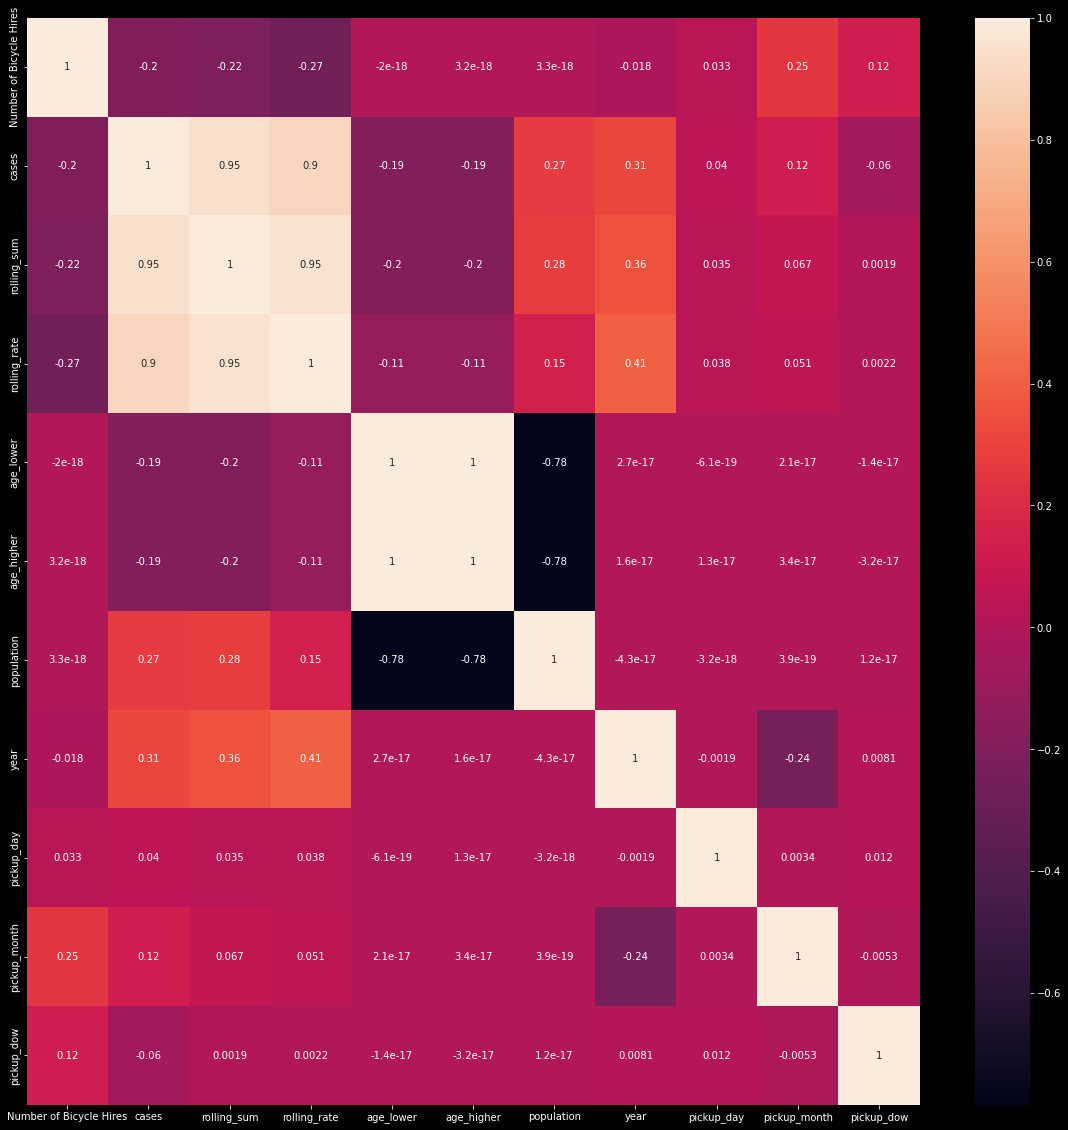

In [25]:
corrMatrix = bike_rentals_covid.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [26]:
import json
cycling_load = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"cycling-load.json"))

# insert loop here to download and concate data
tfl = pd.read_csv(cycling_load['entries'][1]['url'])

In [27]:
tfl.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,51053344,60,8158,24/01/2016 00:01,465.0,"Pitfield Street North,Hoxton",24/01/2016 00:00,569,"Pitfield Street Central, Hoxton"
1,51053345,1440,6975,24/01/2016 00:24,201.0,"Dorset Square, Marylebone",24/01/2016 00:00,430,"South Parade, Chelsea"
2,51053346,1860,11995,24/01/2016 00:31,584.0,"Ilchester Gardens, Bayswater",24/01/2016 00:00,335,"Tavistock Street, Covent Garden"
3,51053347,240,8268,24/01/2016 00:04,218.0,"St. Luke's Church, Chelsea",24/01/2016 00:00,589,"Drayton Gardens, West Chelsea"
4,51053348,1680,12776,24/01/2016 00:29,340.0,"Bank of England Museum, Bank",24/01/2016 00:01,238,"Frampton Street, Paddington"


In [36]:
bike_rentals.shape

(4204, 2)